In [119]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from sklearn.model_selection import LeaveOneOut

from IPython.display import clear_output, display
from tqdm.auto import tqdm
import os
import cv2
import numpy as np
from PIL import Image
from copy import deepcopy

import warnings

warnings.filterwarnings("ignore")  # To ignore any warnings during training

In [120]:
FEATURE_DIM = 32
LSTM_HIDDEN = 16
MLP_HIDDEN = 8
NUM_LAYERS = 2
FREEZE_CNN = True
EFFICIENT_NET_DIM = 1280  # For EfficientNetB0

EFFICIENT_NET_VERSION = 'efficientnet_b0'

if (EFFICIENT_NET_VERSION == 'efficientnet_b0'):
    EFFICIENT_NET_DIM = 1280
elif (EFFICIENT_NET_VERSION == 'efficientnet_b3'):
    EFFICIENT_NET_DIM = 1536
elif (EFFICIENT_NET_VERSION == 'efficientnet_b7'):
    EFFICIENT_NET_DIM = 2560

EPOCHS = 100
BATCH_SIZE = 12
PATIENCE = 80

In [121]:
class SequenceAugmenter:
    """
    Augmentasi untuk sequence frames wajah drowsiness detection.
    Setiap sequence (30 frame) akan diaugmentasi dengan 5 variasi.
    """
    
    @staticmethod
    def horizontal_flip(image):
        """Flip horizontal untuk simulasi arah pandang berbeda"""
        return cv2.flip(image, 1)
    
    @staticmethod
    def brightness_adjust(image, beta=15):
        """Adjust brightness ±15 untuk simulasi pencahayaan berbeda"""
        return cv2.convertScaleAbs(image, alpha=1.0, beta=beta)
    
    @staticmethod
    def rotate(image, angle=5):
        """Rotasi ±5° untuk simulasi kepala miring"""
        h, w = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        return cv2.warpAffine(image, M, (w, h))
    
    @staticmethod
    def gaussian_blur(image, kernel_size=(3, 3)):
        """Gaussian blur untuk simulasi kamera kurang fokus"""
        return cv2.GaussianBlur(image, kernel_size, 0)
    
    def augment_sequence(self, sequence_folder, output_base_folder, base_name):
        """
        Augmentasi satu sequence folder (30 frame) menjadi 5 versi
        """
        from pathlib import Path
        
        augmentation_configs = [
            ('_original', None),  # Original (just copy)
            ('_hflip', self.horizontal_flip),
            ('_bright', lambda img: self.brightness_adjust(img, beta=15)),
            ('_rot', lambda img: self.rotate(img, angle=5)),
            ('_blur', lambda img: self.gaussian_blur(img, kernel_size=(3, 3)))
        ]
        
        # Get all frame files
        frame_files = sorted([f for f in os.listdir(sequence_folder) if f.endswith('.jpg')])
        
        if len(frame_files) == 0:
            print(f"⚠️  No frames found in {sequence_folder}")
            return 0
        
        created_folders = []
        
        # Apply each augmentation
        for suffix, aug_func in augmentation_configs:
            # Create output folder
            output_folder = Path(output_base_folder) / f"{base_name}{suffix}"
            output_folder.mkdir(parents=True, exist_ok=True)
            
            # Process each frame
            for frame_file in frame_files:
                frame_path = os.path.join(sequence_folder, frame_file)
                output_path = output_folder / frame_file
                
                # Read image
                img = cv2.imread(frame_path)
                
                if img is None:
                    continue
                
                # Apply augmentation (or just copy if original)
                if aug_func is not None:
                    img_aug = aug_func(img)
                else:
                    img_aug = img
                
                # Save augmented frame
                cv2.imwrite(str(output_path), img_aug)
            
            created_folders.append(output_folder.name)
        
        return len(augmentation_configs)

print("✓ SequenceAugmenter class defined")

✓ SequenceAugmenter class defined


In [122]:
# # Augmentasi semua data
# from pathlib import Path

# input_dir = Path(r"./output")
# output_dir = Path(r"./output_augmented")
# augmenter = SequenceAugmenter()

# categories = [
#     ('drowsiness_faces', 'drowsiness_faces'),
#     ('non-drowsiness_faces', 'non-drowsiness_faces')
# ]

# total_original = 0
# total_augmented = 0

# print("=" * 80)
# print("DATA AUGMENTATION FOR DROWSINESS DETECTION")
# print("=" * 80)

# for input_category, output_category in categories:
#     input_cat_dir = input_dir / input_category
#     output_cat_dir = output_dir / output_category
    
#     if not input_cat_dir.exists():
#         print(f"⚠️  Directory not found: {input_cat_dir}")
#         continue
    
#     # Create output category directory
#     output_cat_dir.mkdir(parents=True, exist_ok=True)
    
#     # Get all sequence folders
#     sequence_folders = [f for f in os.listdir(input_cat_dir) 
#                       if os.path.isdir(os.path.join(input_cat_dir, f)) 
#                       and f != "manifest.csv"]
    
#     print(f"\n📁 Processing {input_category}:")
#     print(f"   Found {len(sequence_folders)} sequences")
    
#     # Process each sequence with progress bar
#     for seq_folder in tqdm(sequence_folders, desc=f"   Augmenting {input_category}"):
#         seq_path = input_cat_dir / seq_folder
        
#         # Augment this sequence
#         n_versions = augmenter.augment_sequence(seq_path, output_cat_dir, seq_folder)
        
#         if n_versions > 0:
#             total_original += 1
#             total_augmented += n_versions
    
#     print(f"   ✓ Completed {len(sequence_folders)} sequences → {len(sequence_folders) * 5} augmented versions")

# print("\n" + "=" * 80)
# print("AUGMENTATION COMPLETE!")
# print("=" * 80)
# print(f"Original sequences:   {total_original}")
# print(f"Augmented versions:   {total_augmented}")
# print(f"Total sequences:      {total_augmented}")
# print(f"Augmentation factor:  5x")
# print(f"Output directory:     {output_dir}")
# print("=" * 80)

In [123]:
class DrowsinessDataset(Dataset):
    def __init__(self, video_folders, labels, transform=None, num_frames=30):
        self.video_folders = video_folders
        self.labels = labels
        self.transform = transform
        self.num_frames = num_frames
    
    def __len__(self):
        return len(self.video_folders)
    
    def __getitem__(self, idx):
        folder_path = self.video_folders[idx]
        label = self.labels[idx]
        
        # Load semua frames dari folder
        frames = []
        for i in range(1, self.num_frames + 1):
            frame_path = os.path.join(folder_path, f"{i:02d}.jpg")
            
            if os.path.exists(frame_path):
                img = Image.open(frame_path).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                frames.append(img)
            else:
                # Jika frame tidak ada, gunakan frame kosong
                if self.transform:
                    img = self.transform(Image.new('RGB', (224, 224)))
                else:
                    img = torch.zeros(3, 224, 224)
                frames.append(img)
        
        # Stack frames menjadi tensor (num_frames, channels, height, width)
        frames = torch.stack(frames)
        
        return frames, label

In [124]:
# Transform untuk preprocessing
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# transform the image into grayscale
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [125]:
# # Update dataset untuk menggunakan data yang sudah diaugmentasi
# # CATATAN: Jalankan cell augmentasi terlebih dahulu sebelum menjalankan cell ini!

# output_dir_augmented = r"./output_augmented"
# drowsiness_dir_aug = os.path.join(output_dir_augmented, "drowsiness_faces")
# non_drowsiness_dir_aug = os.path.join(output_dir_augmented, "non-drowsiness_faces")

# # Cek apakah folder augmented sudah ada
# if not os.path.exists(output_dir_augmented):
#     print(f"⚠️  Folder augmented belum ada: {output_dir_augmented}")
#     print("⚠️  Silakan jalankan cell augmentasi terlebih dahulu!")
#     print("\nSkipping augmented dataset loading...")
# else:
#     # Kumpulkan semua folder video dan labelnya dari data augmented
#     video_folders_aug = []
#     labels_aug = []

#     # Label 1 untuk drowsiness
#     for folder_name in os.listdir(drowsiness_dir_aug):
#         folder_path = os.path.join(drowsiness_dir_aug, folder_name)
#         if os.path.isdir(folder_path) and folder_name != "manifest.csv":
#             video_folders_aug.append(folder_path)
#             labels_aug.append(1)  # drowsiness = 1

#     # Label 0 untuk non-drowsiness
#     for folder_name in os.listdir(non_drowsiness_dir_aug):
#         folder_path = os.path.join(non_drowsiness_dir_aug, folder_name)
#         if os.path.isdir(folder_path) and folder_name != "manifest.csv":
#             video_folders_aug.append(folder_path)
#             labels_aug.append(0)  # non-drowsiness = 0

#     # Buat dataset dengan data augmented
#     full_dataset_aug = DrowsinessDataset(video_folders_aug, labels_aug, transform=transform)

#     length_train_data = len(os.listdir('./train/drowsiness_separated')) + len(os.listdir('./train/non-drowsiness_separated'))
#     length_val_data = len(os.listdir('./output_val/0')) + len(os.listdir('./output_val/1'))

#     # Print informasi dataset
#     print(f"\n{'='*80}")
#     print("AUGMENTED DATASET INFO")
#     print(f"{'='*80}")
#     print(f"Total data: {len(video_folders_aug)}")
#     print(f"Drowsiness samples: {sum(labels_aug)}")
#     print(f"Non-drowsiness samples: {len(labels_aug) - sum(labels_aug)}")
#     print(f"\nOriginal training dataset: {length_train_data} sequences")
#     print(f"Augmented training dataset: {len(video_folders_aug)} sequences")
#     print(f"Increase: {len(video_folders_aug) / length_train_data:.1f}x")
#     print(f"\nValidation dataset tetap: {length_val_data} sequences")
#     print(f"{'='*80}")
    
#     # Update train_dataset dengan augmented version
#     train_dataset = DrowsinessDataset(video_folders_aug, labels_aug, transform=transform)
#     print(f"\n✓ Training dataset updated dengan augmented data")
#     print(f"  Training: {len(train_dataset)} samples")
#     print(f"  Validation: {length_val_data} samples")

DATASET INFORMATION

TRAINING SET:
  Total data: 240
  Drowsiness samples: 120
  Non-drowsiness samples: 120

VALIDATION SET:
  Total data: 150
  Drowsiness samples: 45
  Non-drowsiness samples: 105

Total samples: 390
Sample 1 - Label: Drowsiness


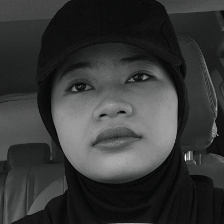

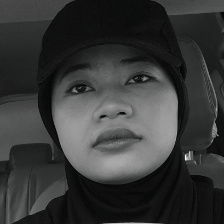

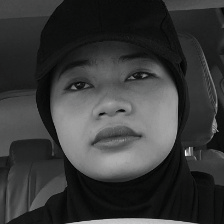

In [126]:


# Path ke folder output untuk TRAINING
output_dir = r"./mp_output"
drowsiness_dir = os.path.join(output_dir, "drowsiness_faces")
non_drowsiness_dir = os.path.join(output_dir, "non-drowsiness_faces")

# Kumpulkan semua folder video dan labelnya untuk TRAINING
train_video_folders = []
train_labels = []

# Label 1 untuk drowsiness
for folder_name in os.listdir(drowsiness_dir):
    folder_path = os.path.join(drowsiness_dir, folder_name)
    if os.path.isdir(folder_path) and folder_name != "manifest.csv":
        train_video_folders.append(folder_path)
        train_labels.append(1)  # drowsiness = 1

# Label 0 untuk non-drowsiness
for folder_name in os.listdir(non_drowsiness_dir):
    folder_path = os.path.join(non_drowsiness_dir, folder_name)
    if os.path.isdir(folder_path) and folder_name != "manifest.csv":
        train_video_folders.append(folder_path)
        train_labels.append(0)  # non-drowsiness = 0

# Path ke folder output_val untuk VALIDATION
val_dir = r"./output_val"
val_drowsy_dir = os.path.join(val_dir, "1")  # Label 1 = drowsy
val_non_drowsy_dir = os.path.join(val_dir, "0")  # Label 0 = non-drowsy

# Kumpulkan semua folder video dan labelnya untuk VALIDATION
val_video_folders = []
val_labels = []

# Label 1 untuk drowsiness (folder "1")
for folder_name in os.listdir(val_drowsy_dir):
    folder_path = os.path.join(val_drowsy_dir, folder_name)
    if os.path.isdir(folder_path) and folder_name != "manifest.csv":
        val_video_folders.append(folder_path)
        val_labels.append(1)

# Label 0 untuk non-drowsiness (folder "0")
for folder_name in os.listdir(val_non_drowsy_dir):
    folder_path = os.path.join(val_non_drowsy_dir, folder_name)
    if os.path.isdir(folder_path) and folder_name != "manifest.csv":
        val_video_folders.append(folder_path)
        val_labels.append(0)


# Buat dataset untuk TRAINING dan VALIDATION
train_dataset = DrowsinessDataset(train_video_folders, train_labels, transform=transform)
val_dataset = DrowsinessDataset(val_video_folders, val_labels, transform=transform)

# Print informasi dataset
print(f"="*80)
print("DATASET INFORMATION")
print(f"="*80)
print(f"\nTRAINING SET:")
print(f"  Total data: {len(train_video_folders)}")
print(f"  Drowsiness samples: {sum(train_labels)}")
print(f"  Non-drowsiness samples: {len(train_labels) - sum(train_labels)}")
print(f"\nVALIDATION SET:")
print(f"  Total data: {len(val_video_folders)}")
print(f"  Drowsiness samples: {sum(val_labels)}")
print(f"  Non-drowsiness samples: {len(val_labels) - sum(val_labels)}")
print(f"\nTotal samples: {len(train_video_folders) + len(val_video_folders)}")
print(f"="*80)



# display top 5 images from training dataset
for i in range(1):
    frames, label = train_dataset[i]
    print(f"Sample {i+1} - Label: {'Drowsiness' if label == 1 else 'Non-drowsiness'}")
    for j in range(frames.shape[0]):
        if j >= 3:
            break
        img = frames[j].permute(1, 2, 0).numpy()
        img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))  # Denormalize
        img = np.clip(img, 0, 1)
        display(Image.fromarray((img * 255).astype(np.uint8)))

In [127]:
import timm
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [128]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# CUDA optimization
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

Using device: cuda
GPU: NVIDIA GeForce RTX 3070
CUDA Version: 12.1


In [129]:
class EfficientNetFeatureExtractor(nn.Module):
    def __init__(self, feature_dim=256, freeze=True):
        super().__init__()
        # Load pretrained EfficientNetB0
        self.effnet = timm.create_model(EFFICIENT_NET_VERSION, pretrained=True, num_classes=0)
        
        # Freeze backbone
        if freeze:
            for param in self.effnet.parameters():
                param.requires_grad = False
        
        # Bottleneck layer: 1280 -> 256
        self.bottleneck = nn.Sequential(
            nn.Linear(EFFICIENT_NET_DIM, feature_dim),
            nn.ReLU(),
            nn.Dropout(0.2)  # Reduced dropout for small dataset
        )
    
    def forward(self, x):
        # x: (B*T, C, H, W)
        features = self.effnet(x)  # (B*T, 1280)
        features = self.bottleneck(features)  # (B*T, 256)
        return features

In [130]:
class LSTMEncoder(nn.Module):
    def __init__(self, input_size=256, hidden_size=128, num_layers=1, bidirectional=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=0.3  # No dropout karena 1 layer
        )
    
    def forward(self, x):
        # x: (B, T, F)
        out, (h_n, c_n) = self.lstm(x)
        # out: (B, T, hidden_size * 2) jika bidirectional
        # Ambil output di time step terakhir
        last_out = out[:, -1, :]  # (B, hidden_size * 2)
        return last_out

In [131]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size=256, hidden_size=64, num_classes=1):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),  # Reduced dropout for small dataset
            nn.Linear(hidden_size, num_classes)
        )
    
    def forward(self, x):
        return self.classifier(x)

In [132]:
class DrowsinessDetector(nn.Module):
    def __init__(self, feature_dim=256, lstm_hidden=128, mlp_hidden=64, num_layers=2, freeze_cnn=True):
        super().__init__()
        self.feature_extractor = EfficientNetFeatureExtractor(feature_dim=feature_dim, freeze=freeze_cnn)
        
        lstm_output_size = lstm_hidden * 2  # bidirectional
        self.temporal_encoder = LSTMEncoder(input_size=feature_dim, hidden_size=lstm_hidden, bidirectional=True, num_layers=num_layers)
        self.classifier = MLPClassifier(input_size=lstm_output_size, hidden_size=mlp_hidden, num_classes=1)
    
    def forward(self, x):
        # x: (B, T, C, H, W)
        B, T, C, H, W = x.shape
        
        # Reshape untuk feature extraction
        x = x.view(B * T, C, H, W)  # (B*T, C, H, W)
        
        # Extract features
        features = self.feature_extractor(x)  # (B*T, feature_dim)
        
        # Reshape kembali untuk LSTM
        features = features.view(B, T, -1)  # (B, T, feature_dim)
        
        # LSTM encoding
        lstm_out = self.temporal_encoder(features)  # (B, lstm_hidden*2)
        
        # Classification
        logits = self.classifier(lstm_out)  # (B, 1)
        
        return logits.squeeze(-1)  # (B,)

In [133]:
# Model akan dibuat ulang di setiap fold LOOCV
# Ini hanya untuk melihat arsitektur
model_template = DrowsinessDetector(
    feature_dim=FEATURE_DIM,
    lstm_hidden=LSTM_HIDDEN,
    mlp_hidden=MLP_HIDDEN,
    num_layers=NUM_LAYERS,
    freeze_cnn=FREEZE_CNN
).to(device)

# Hitung parameter
total_params = sum(p.numel() for p in model_template.parameters())
trainable_params = sum(p.numel() for p in model_template.parameters() if p.requires_grad)

print(f"Model Architecture:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")

Model Architecture:
Total parameters: 4,061,613
Trainable parameters: 54,065
Frozen parameters: 4,007,548


In [134]:
# Hitung class weights untuk menangani imbalance (dari training set)
num_drowsy = sum(train_labels)
num_non_drowsy = len(train_labels) - num_drowsy
pos_weight_value = num_non_drowsy / num_drowsy

print(f"Class distribution (Training Set):")
print(f"  Non-drowsy: {num_non_drowsy}")
print(f"  Drowsy: {num_drowsy}")
print(f"  Pos weight for BCE Loss: {pos_weight_value:.2f}")

Class distribution (Training Set):
  Non-drowsy: 120
  Drowsy: 120
  Pos weight for BCE Loss: 1.00


In [135]:
def train_one_epoch(model, train_loader, criterion, optimizer, device, use_amp=True, verbose=False):
    model.train()
    running_loss = 0.0
    predictions = []
    targets = []
    
    scaler = torch.cuda.amp.GradScaler() if use_amp else None
    
    for batch_idx, (frames, labels) in enumerate(train_loader):
        frames = frames.to(device, non_blocking=False)  # Changed to blocking to avoid memory fragmentation
        labels = labels.float().to(device, non_blocking=False)
        
        optimizer.zero_grad()
        
        if use_amp and torch.cuda.is_available():
            with torch.cuda.amp.autocast():
                logits = model(frames)
                loss = criterion(logits, labels)
            
            if torch.isnan(loss):
                if verbose:
                    print(f"⚠️ NaN loss detected at batch {batch_idx}")
                continue
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(frames)
            loss = criterion(logits, labels)
            
            if torch.isnan(loss):
                if verbose:
                    print(f"⚠️ NaN loss detected at batch {batch_idx}")
                continue
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        running_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        predictions.extend(preds.cpu().numpy())
        targets.extend(labels.cpu().numpy())
        
        # Clear GPU cache after each batch to prevent memory buildup
        if torch.cuda.is_available():
            del frames, labels, logits, preds
            torch.cuda.empty_cache()
    
    epoch_loss = running_loss / max(len(train_loader), 1)
    epoch_acc = accuracy_score(targets, predictions) if len(targets) > 0 else 0.0
    
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    """Validate on validation set"""
    model.eval()
    running_loss = 0.0
    predictions = []
    targets = []
    
    with torch.no_grad():
        for frames, labels in val_loader:
            frames = frames.to(device, non_blocking=False)  # Changed to blocking to avoid memory fragmentation
            labels = labels.float().to(device, non_blocking=False)
            
            logits = model(frames)
            loss = criterion(logits, labels)
            
            running_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            predictions.extend(preds.cpu().numpy())
            targets.extend(labels.cpu().numpy())
            
            # Clear GPU cache after each batch to prevent memory buildup
            if torch.cuda.is_available():
                del frames, labels, logits, preds
                torch.cuda.empty_cache()
    
    val_loss = running_loss / max(len(val_loader), 1)
    val_acc = accuracy_score(targets, predictions) if len(targets) > 0 else 0.0
    val_precision = precision_score(targets, predictions, zero_division=0) if len(targets) > 0 else 0.0
    val_recall = recall_score(targets, predictions, zero_division=0) if len(targets) > 0 else 0.0
    val_f1 = f1_score(targets, predictions, zero_division=0) if len(targets) > 0 else 0.0
    
    return val_loss, val_acc, val_precision, val_recall, val_f1, predictions, targets

In [ ]:
# Clear GPU cache before training
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"GPU Mem before training: {torch.cuda.memory_allocated()/1024**3:.2f} GB")

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                          num_workers=0, pin_memory=False)  # Disable pin_memory to save GPU memory
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=0, pin_memory=False)

# Initialize model
model = DrowsinessDetector(
    feature_dim=FEATURE_DIM,
    lstm_hidden=LSTM_HIDDEN,
    mlp_hidden=MLP_HIDDEN,
    num_layers=NUM_LAYERS,
    freeze_cnn=FREEZE_CNN
).to(device)

# Setup optimizer and loss
pos_weight = torch.tensor([pos_weight_value]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4,
    weight_decay=1e-4
)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_precision': [],
    'val_recall': [],
    'val_f1': [],
    'lr': []
}

print("=" * 80)
print("TRAINING START")
print("=" * 80)
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Early stopping patience: {PATIENCE}")
print("=" * 80)

# Training loop
best_val_loss = float('inf')
best_val_acc = 0.0
patience_counter = 0
best_epoch = 0

try:
    for epoch in range(EPOCHS):
        
        print(f"\n{'='*80}")
        print(f"Epoch {epoch+1}/{EPOCHS}\n")
        
        # Training
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device, use_amp=True, verbose=False
        )
        
        # Validation
        val_loss, val_acc, val_precision, val_recall, val_f1, val_preds, val_targets = validate(
            model, val_loader, criterion, device
        )
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)
        history['lr'].append(current_lr)
        
        # Print epoch results
        
        print(f"\nTrain - Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
        print(f"Val   - Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | "
              f"Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1: {val_f1:.4f}")
        print(f"LR: {current_lr:.6f}")

        # # plot graph for each epoch, then clear the output for each epoch
        # plt.figure(figsize=(12, 5))
        # plt.subplot(1, 2, 2)
        # plt.plot(history['train_acc'], label='Train Acc')
        # plt.plot(history['val_acc'], label='Val Acc')
        # plt.xlabel('Epoch')
        # plt.ylabel('Accuracy')
        # plt.title('Accuracy over Epochs')
        # plt.legend()
        # plt.tight_layout()
        # plt.show()
        

        
        # Early stopping and model saving based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_epoch = epoch + 1
            patience_counter = 0
            best_model_state = deepcopy(model.state_dict())
            print(f"✓ Best model (Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f})")
            
            # Save best model
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc,
                'history': history
            }, 'best_model.pth')
        else:
            patience_counter += 1
            print(f"Patience: {patience_counter}/{PATIENCE}")
        
        if patience_counter >= PATIENCE:
            print(f"\n🛑 Early stopping at epoch {epoch + 1}")
            break
    
    print("\n" + "=" * 80)
    print("TRAINING COMPLETE!")
    print("=" * 80)
    print(f"Best epoch: {best_epoch}")
    print(f"Best val loss: {best_val_loss:.4f}")
    print(f"Best val accuracy: {best_val_acc:.4f}")
    print("=" * 80)
    
    # Load best model for final evaluation
    model.load_state_dict(best_model_state)

except KeyboardInterrupt:
    print("\n" + "=" * 80)
    print("⚠️ TRAINING INTERRUPTED BY USER")
    print("=" * 80)
    
    if len(history['train_loss']) > 0:
        # Save partial model
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history
        }, 'interrupted_model.pth')
        print(f"\n💾 Model saved to 'interrupted_model.pth'")
        print(f"Completed {epoch + 1} epochs")
    
    print("\n" + "=" * 80)

GPU Mem before training: 0.06 GB
TRAINING START
Training samples: 240
Validation samples: 150
Epochs: 100
Batch size: 12
Early stopping patience: 80

Epoch 1/100



In [ ]:
torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_loss': val_loss,
    'val_acc': val_acc,
    'history': history
}, 'best_model.pth')

In [ ]:
# Final Evaluation on Validation Set
print("\n" + "=" * 80)
print("FINAL EVALUATION ON VALIDATION SET")
print("=" * 80)

val_loss, val_acc, val_precision, val_recall, val_f1, val_preds, val_targets = validate(
    model, val_loader, criterion, device
)

# Convert to numpy arrays
y_true = np.array(val_targets)
y_pred = np.array(val_preds)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

print(f"\nOverall Metrics:")
print(f"  Accuracy:      {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"  Precision:     {val_precision:.4f}")
print(f"  Recall:        {val_recall:.4f}")
print(f"  F1-Score:      {val_f1:.4f}")

print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"                 Non-Drowsy  Drowsy")
print(f"Actual Non-Drowsy    {cm[0,0]:3d}       {cm[0,1]:3d}")
print(f"Actual Drowsy        {cm[1,0]:3d}       {cm[1,1]:3d}")

print(f"\nPer-Class Metrics:")
if cm[0,0] + cm[0,1] > 0:
    non_drowsy_acc = cm[0,0] / (cm[0,0] + cm[0,1])
    print(f"  Non-Drowsy Accuracy: {non_drowsy_acc:.4f} ({non_drowsy_acc*100:.2f}%)")
if cm[1,0] + cm[1,1] > 0:
    drowsy_acc = cm[1,1] / (cm[1,0] + cm[1,1])
    print(f"  Drowsy Accuracy:     {drowsy_acc:.4f} ({drowsy_acc*100:.2f}%)")

# Save results
import pandas as pd
results_df = pd.DataFrame(history)
results_df.to_csv('training_history.csv', index=False)
print(f"\nTraining history saved to 'training_history.csv'")


FINAL EVALUATION ON VALIDATION SET

Overall Metrics:
  Accuracy:      0.7333 (73.33%)
  Precision:     0.5490
  Recall:        0.6222
  F1-Score:      0.5833

Confusion Matrix:
                 Predicted
                 Non-Drowsy  Drowsy
Actual Non-Drowsy     82        23
Actual Drowsy         17        28

Per-Class Metrics:
  Non-Drowsy Accuracy: 0.7810 (78.10%)
  Drowsy Accuracy:     0.6222 (62.22%)

Training history saved to 'training_history.csv'


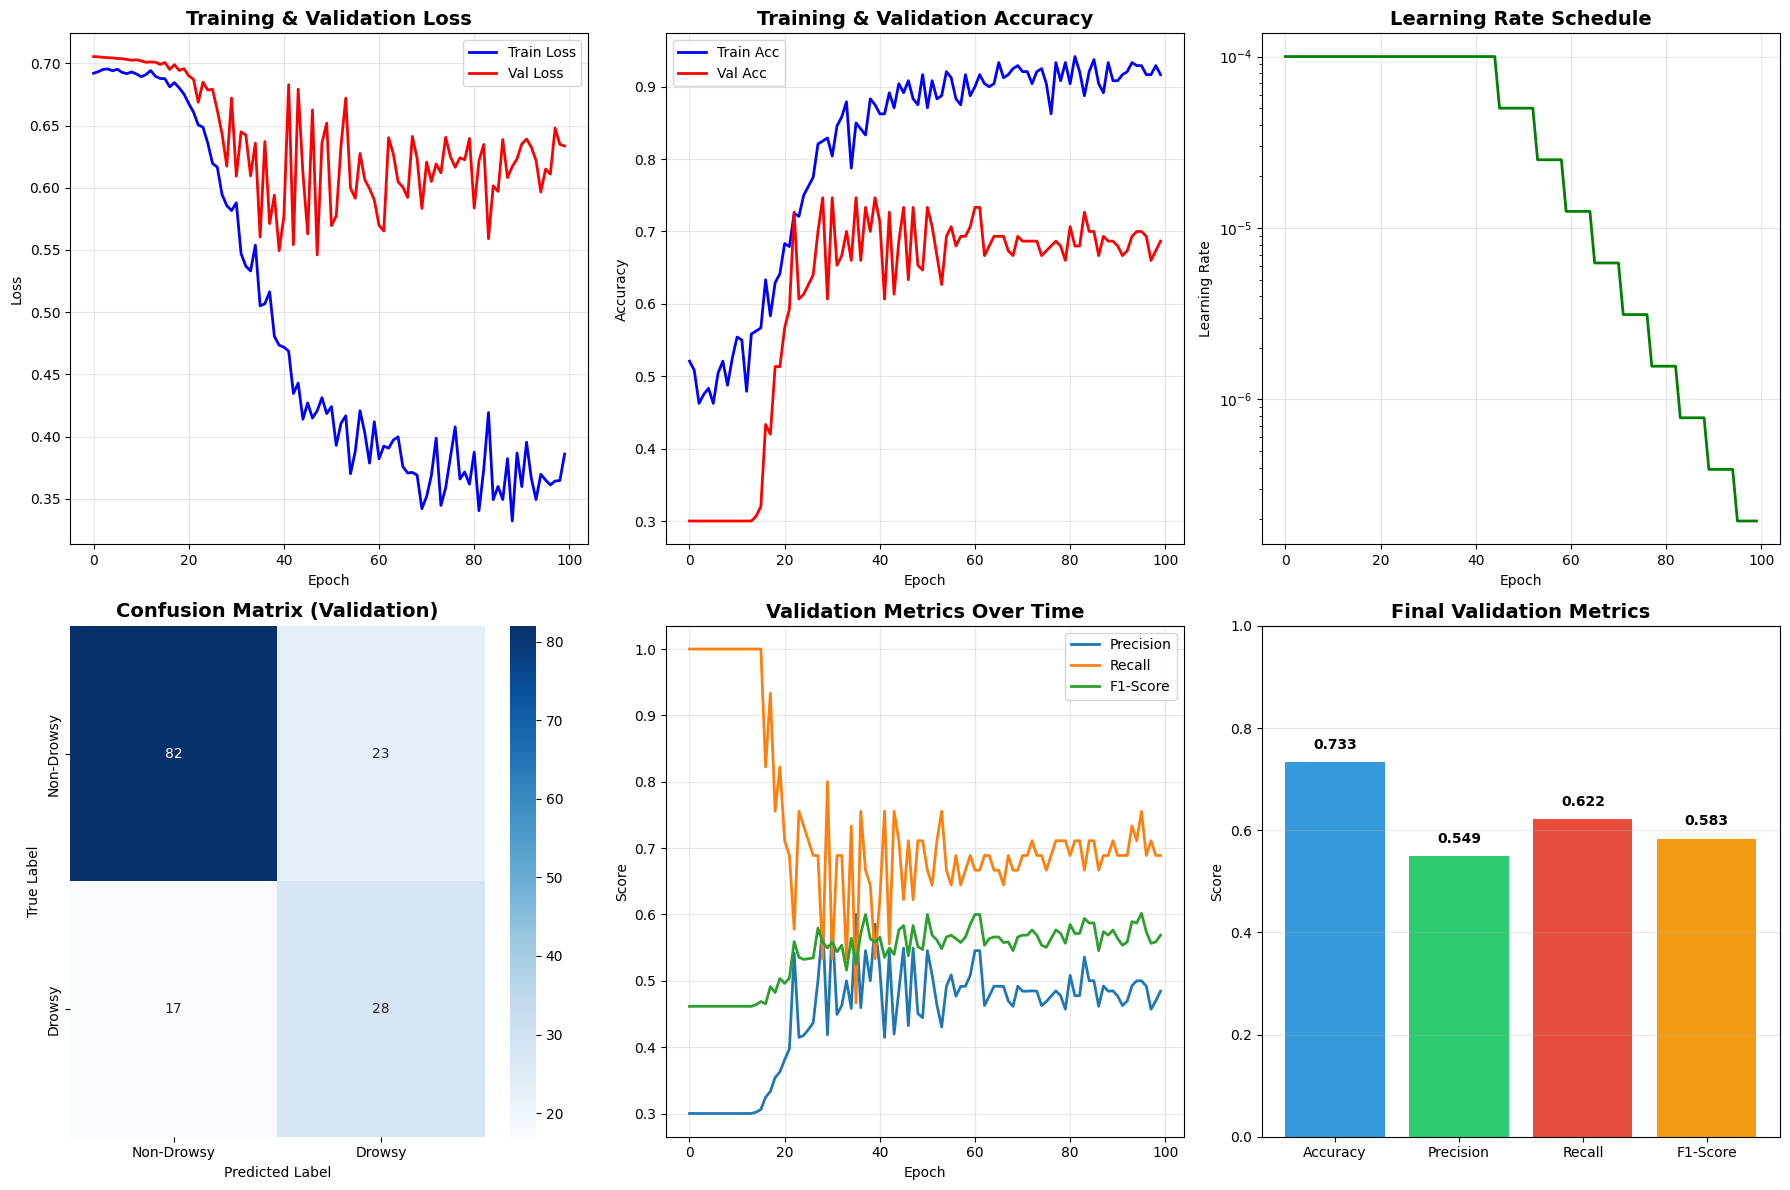


Visualization saved to 'training_results.png'


In [ ]:
# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Training & Validation Loss
ax = axes[0, 0]
ax.plot(history['train_loss'], label='Train Loss', color='blue', linewidth=2)
ax.plot(history['val_loss'], label='Val Loss', color='red', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 2. Training & Validation Accuracy
ax = axes[0, 1]
ax.plot(history['train_acc'], label='Train Acc', color='blue', linewidth=2)
ax.plot(history['val_acc'], label='Val Acc', color='red', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 3. Learning Rate
ax = axes[0, 2]
ax.plot(history['lr'], color='green', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Learning Rate')
ax.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.grid(alpha=0.3)

# 4. Confusion Matrix
ax = axes[1, 0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Non-Drowsy', 'Drowsy'],
            yticklabels=['Non-Drowsy', 'Drowsy'])
ax.set_title('Confusion Matrix (Validation)', fontsize=14, fontweight='bold')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

# 5. Validation Metrics Over Time
ax = axes[1, 1]
ax.plot(history['val_precision'], label='Precision', linewidth=2)
ax.plot(history['val_recall'], label='Recall', linewidth=2)
ax.plot(history['val_f1'], label='F1-Score', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Score')
ax.set_title('Validation Metrics Over Time', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 6. Final Metrics Bar Chart
ax = axes[1, 2]
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values = [val_acc, val_precision, val_recall, val_f1]
bars = ax.bar(metrics_names, metrics_values, color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'])
ax.set_ylim([0, 1])
ax.set_ylabel('Score')
ax.set_title('Final Validation Metrics', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, metrics_values):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved to 'training_results.png'")

In [ ]:
# Summary Report
print("\n" + "=" * 80)
print("TRAINING SUMMARY REPORT")
print("=" * 80)

print(f"\nDataset Information:")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")
print(f"  Training drowsy: {sum(train_labels)}")
print(f"  Training non-drowsy: {len(train_labels) - sum(train_labels)}")
print(f"  Validation drowsy: {sum(val_labels)}")
print(f"  Validation non-drowsy: {len(val_labels) - sum(val_labels)}")

print(f"\nModel Architecture:")
print(f"  Feature Extractor: EfficientNetB3 (frozen)")
print(f"  Temporal Encoder: Bidirectional LSTM (hidden={LSTM_HIDDEN})")
print(f"  Classifier: MLP ({FEATURE_DIM}→{MLP_HIDDEN}→1)")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

print(f"\nTraining Configuration:")
print(f"  Total epochs: {len(history['train_loss'])}")
print(f"  Best epoch: {best_epoch}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Initial learning rate: 5e-4")
print(f"  Final learning rate: {history['lr'][-1]:.6f}")
print(f"  Optimizer: Adam")
print(f"  Loss: BCEWithLogitsLoss (pos_weight={pos_weight_value:.2f})")
print(f"  Scheduler: ReduceLROnPlateau")

print(f"\nBest Training Performance:")
print(f"  Train Loss: {min(history['train_loss']):.4f}")
print(f"  Train Accuracy: {max(history['train_acc']):.4f} ({max(history['train_acc'])*100:.2f}%)")

print(f"\nFinal Validation Performance:")
print(f"  Val Loss:      {val_loss:.4f}")
print(f"  Val Accuracy:  {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"  Val Precision: {val_precision:.4f}")
print(f"  Val Recall:    {val_recall:.4f}")
print(f"  Val F1-Score:  {val_f1:.4f}")

print(f"\nConfusion Matrix:")
print(f"  True Negatives:  {cm[0,0]}")
print(f"  False Positives: {cm[0,1]}")
print(f"  False Negatives: {cm[1,0]}")
print(f"  True Positives:  {cm[1,1]}")

print("\n" + "=" * 80)
print("Training Complete!")
print("=" * 80)


TRAINING SUMMARY REPORT

Dataset Information:
  Training samples: 240
  Validation samples: 150
  Training drowsy: 120
  Training non-drowsy: 120
  Validation drowsy: 45
  Validation non-drowsy: 105

Model Architecture:
  Feature Extractor: EfficientNetB3 (frozen)
  Temporal Encoder: Bidirectional LSTM (hidden=16)
  Classifier: MLP (32→8→1)
  Total parameters: 4,061,613
  Trainable parameters: 54,065

Training Configuration:
  Total epochs: 100
  Best epoch: 48
  Batch size: 12
  Initial learning rate: 5e-4
  Final learning rate: 0.000000
  Optimizer: Adam
  Loss: BCEWithLogitsLoss (pos_weight=1.00)
  Scheduler: ReduceLROnPlateau

Best Training Performance:
  Train Loss: 0.3322
  Train Accuracy: 0.9417 (94.17%)

Final Validation Performance:
  Val Loss:      0.5461
  Val Accuracy:  0.7333 (73.33%)
  Val Precision: 0.5490
  Val Recall:    0.6222
  Val F1-Score:  0.5833

Confusion Matrix:
  True Negatives:  82
  False Positives: 23
  False Negatives: 17
  True Positives:  28

Training C